In [37]:
import os
import random
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import RootMeanSquaredError, BinaryCrossentropy, SparseCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
import matplotlib.pyplot as plt
import seaborn as sb
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from itertools import combinations

tqdm.pandas()
np.set_printoptions(edgeitems=3, infstr="inf", linewidth=75, nanstr="nan", precision=8, suppress=False, threshold=1000, formatter=None)
plt.style.use("dark_background")

C:\Users\82104\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [29]:
# age: (0~4: 0, 5~9: 1, 10~14: 2, ...)
users = pd.read_csv("Datasets/MovieLens 100k/100k_users.csv")
# year: 영화 개봉 연도
movies = pd.read_csv("Datasets/MovieLens 100k/100k_movies.csv")
ratings = pd.read_csv("Datasets/MovieLens 100k/100k_ratings.csv")

data = pd.merge(ratings, users, on="user_id")
data = pd.merge(data, movies, on="item_id")

# Label Encoding

In [35]:
cols = ["user_id", "item_id", "age", "gender", "occupation", "year"] + data.loc[:, "unknown":"Western"].columns.tolist()
# col2size = {}
for col in cols:
    data[col] = pd.Categorical(data[col])
#     col2size[col] = len(data[col].col.colegories)
    data[col] = data[col].cat.codes

## Factorization Machine의 개념

### Feature Vectors
![feature_table](https://i.imgur.com/fTwPYWa.png)

### 기본 아이디어
- degree $d = 2$인 Factorization Machine의 모델은 다음과 같이 정의됩니다. $d = 2$라는 것은 embedding vectors를 최대 2개 조합하겠다는 의미입니다.
$$
\hat{y}(x):=w_0 + \sum_{i=1}^n w_ix_i + \sum_{i=1}^n\sum_{j=i+1}^n w_{i,j}x_ix_j
$$
- $w_0$: Global Bias
- $n$: The Number of Features
- $w_i$: The Weight of $i$th Feature
- $x_i$: The Value of $i$th Feature of the Sample.
- $w_{i,j}$ : The Interactive Weight of $i$th Feature and $j$th Feature
$$
w_{i,j} := \vec{v_i}\cdot\vec{v_j} = \sum_{f=1}^k v_{i,f}v_{j,f}
$$
- $\vec{v_i}$: The Embedding Vector of $i$th Feature

# Modeling

In [310]:
k = 16
cols = ["user_id", "item_id", "age", "year"]
inputs = []
embedding_mlr_list = []
embedding_fm_list = []
for col in cols:
    input_ = Input(shape=(), name=f"Input_{col}")
    input_dim = data[col].nunique()
    embedding_mlr = Embedding(input_dim=input_dim, output_dim=1, name=f"Embedding_{col}")(input_)
    embedding_fm = Embedding(input_dim=input_dim, output_dim=k, name=f"emb_{col}")(input_)
    
    inputs.append(input_)
    embedding_mlr_list.append(embedding_mlr)
    embedding_fm_list.append(embedding_fm)

# Multivariate Linear Regression Part
$$
w_0 + \sum_{i=1}^n w_ix_i
$$
- `tensorflow.keras.layers.Embedding()`를 사용할 경우
$$
w_0 + \sum_{i=1}^n w_i
$$

In [311]:
class MultipleLinearRegression(Layer):
    def build(self, input_shape):
        #global bias를 생성합니다.
        self.w0 = self.add_weight(shape=(1,), initializer="zeros", trainable=True)
        super().build(input_shape)
        
    def call(self, x, **kwargs):
        # Weight를 의미하는 Tensors의 List를 입력받아 모두 더하고(element-wise) Global bias까지 더해서 logits를 만듭니다.
        logits = tf.math.add_n(x) + self.w0
        return logits
    
logits_mlr = MultipleLinearRegression(name="mlr")(weights_list)

### (3) Factorization Machine Part 구현하기
$$
\sum_{i=1}^n\sum_{j=i+1}^nw_{i,j}x_ix_j = \sum_{i=1}^n\sum_{j=i+1}^n(\vec{v_i}\cdot\vec{v_j})x_ix_j = \sum_{i=1}^n\sum_{j=i+1}^n\sum_{f=1}^k v_{i,f}v_{j,f}x_ix_j
$$
- tf.keras.layers.Embedding() 함수를 사용할 경우 다음과 같이 weights만의 연산으로 표현됩니다.
$$
\sum_{i=1}^n\sum_{j=i+1}^n w_{i,j} = \sum_{i=1}^n\sum_{j=i+1}^n(\vec{v_i}\cdot\vec{v_j}) = \sum_{i=1}^n\sum_{j=i+1}^n\sum_{f=1}^k v_{i,f}v_{j,f}
$$
- 이 식의 시간 복잡도는 $O(kn^2)$입니다.
- 이를 다음과 같이 수정하여 시간 복잡도를 $O(kn)$으로 만들 수 있습니다.
$$
\frac{1}{2}\sum_{f=1}^k\left(\left(\sum_{i=1}^nv_{i,f}\right)^2 - \sum_{i=1}^n{v_{i,f}}^2\right)
$$

In [312]:
class FactorizationMachine(Layer):
    def call(self, x, **kwargs):
        #각 feature에 대해 embedding vector를 의미하는 shape=(k, ) tf.Tensors의 list를 입력받아 row 방향으로 쌓아 shape=(n, k)의 tf.Tensor를 만듭니다.
        y = tf.stack(x, axis=0)
        
        logits = 1/2*tf.math.reduce_sum(tf.math.square(tf.math.reduce_sum(y, axis=0)) - tf.math.reduce_sum(tf.square(y), axis=0, keepdims=True), axis=1, keepdims=False)
        return logits
    
logits_fm = FM(name="fm")(embs_list)

### (4) Model 정의하기

In [313]:
logits = logits_mlr + logits_fm

model = Model(inputs=inputs_list, outputs=logits, name="model")

### (5) Dataset 정의하기

In [314]:
# x = data[["user_id", "item_id", "age", "year"]]
x = data.drop(["rating"], axis=1)
y = data[["rating"]]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=12345)

In [315]:
x_train

,user_id,item_id,age,gender,occupation,title,year,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
86332,74,1150,3,1,5,In Love and War (1996),69,0,0,0,...,0,0,0,0,0,1,0,0,1,0
63686,285,400,4,1,18,Ghost (1990),62,0,0,0,...,0,0,0,0,0,1,0,1,0,0
470,307,653,11,1,15,Stand by Me (1986),58,0,0,1,...,0,0,0,0,0,0,0,0,0,0
38029,48,322,3,0,18,Lost Highway (1997),69,0,0,0,...,0,0,0,0,1,0,0,0,0,0
86051,415,725,3,0,18,Immortal Beloved (1994),66,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4094,89,338,11,1,3,Boogie Nights (1997),69,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85412,604,676,5,1,4,Volcano (1997),69,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2177,597,284,7,0,11,"English Patient, The (1996)",68,0,0,0,...,0,0,0,0,0,1,0,0,1,0
77285,157,470,9,1,3,Dragonheart (1996),68,0,1,1,...,1,0,0,0,0,0,0,0,0,0


In [316]:
y_train

,rating
86332,1
63686,3
470,4
38029,4
86051,5
...,...
4094,4
85412,1
2177,5
77285,3


In [317]:
#tensor로 바꿔줍니다.
train_set = tf.data.Dataset.from_tensor_slices(({k:v.values for k, v in x_train.iteritems()}, y_train.values)).shuffle(len(x_train)).batch(batch_size)
val_set = tf.data.Dataset.from_tensor_slices(({k:v.values for k, v in x_val.iteritems()}, y_val.values)).batch(batch_size)

### (6) 학습시키기

In [318]:
%%time
model.compile(optimizer=tf.keras.optimizers.Adagrad(lr=0.2), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])

batch_size = 256
n_epochs = 50
### (5) Dataset 정의하기
hist = model.fit_generator(generator=train_set, validation_data=val_set, epochs=n_epochs)

Epoch 1/50
352/352 [==============================] - 17s 47ms/step - loss: 1.7344 - root_mean_squared_error: 1.3170 - val_loss: 1.2005 - val_root_mean_squared_error: 1.0792
Epoch 2/50
352/352 [==============================] - 16s 46ms/step - loss: 1.0715 - root_mean_squared_error: 1.0350 - val_loss: 1.0264 - val_root_mean_squared_error: 1.0093
Epoch 3/50
352/352 [==============================] - 16s 46ms/step - loss: 0.9705 - root_mean_squared_error: 0.9850 - val_loss: 0.9648 - val_root_mean_squared_error: 0.9835
Epoch 4/50
352/352 [==============================] - 17s 48ms/step - loss: 0.9268 - root_mean_squared_error: 0.9626 - val_loss: 0.9357 - val_root_mean_squared_error: 0.9710
Epoch 5/50
352/352 [==============================] - 15s 43ms/step - loss: 0.9027 - root_mean_squared_error: 0.9500 - val_loss: 0.9148 - val_root_mean_squared_error: 0.9610
Epoch 6/50
352/352 [==============================] - 18s 52ms/step - loss: 0.8877 - root_mean_squared_error: 0.9420 - val_loss: 0

KeyboardInterrupt: 

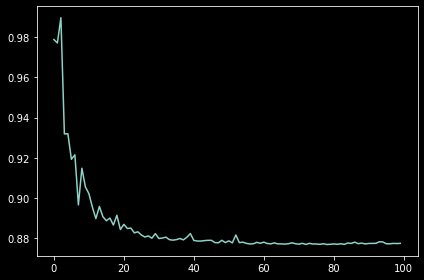

In [327]:
fig, ax = plt.subplots()

ax.plot(hist.history["val_loss"])

fig.tight_layout()